In [1]:
import numpy as np
import tensorflow as tf

In [2]:
DATA_DIR = "../data/"

n_input = 29
n_classes = 2
learning_rate = 0.0005
num_steps = 500
batch_size = 100
display_step = 50

In [3]:
def slicedata(data, dataset):
    trainset = data[dataset]
    features = np.float32(trainset[:,1:-1])
    labels_int = np.int32(trainset[:,-1])
    labels = np.zeros((labels_int.shape[0], n_classes))
    labels[range(labels_int.shape[0]), labels_int] = 1
    return features, labels
    
with np.load(DATA_DIR+"ccdataset.npz") as data:
    features, labels = slicedata(data, 'train')
    features_valid, labels_valid = slicedata(data, 'valid')

In [4]:
# Assume that each row of `features` corresponds to the same row as `labels`.
assert features.shape[0] == labels.shape[0]

features_placeholder = tf.placeholder(tf.float32, [None, n_input])
labels_placeholder = tf.placeholder(tf.float32, [None, n_classes])

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()

X, Y = iterator.get_next()

In [5]:
def Baseline_model(x, n_classes, reuse, is_training):
    with tf.variable_scope('Baseline', reuse=reuse):
        layer1 = tf.layers.dense(inputs=x, units=50, activation=tf.nn.leaky_relu)
        layer2 = tf.layers.dense(inputs=layer1, units=50, activation=tf.nn.leaky_relu)
        layer3 = tf.layers.dense(inputs=layer2, units=50, activation=tf.nn.leaky_relu)
        out = tf.layers.dense(inputs=layer3, units=n_classes)
        out = tf.nn.softmax(out) if not is_training else out
    return out

logits_train = Baseline_model(X, n_classes, reuse=False, is_training=True)
logits_test = Baseline_model(X, n_classes, reuse=True, is_training=False)

In [6]:
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits_train, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

predicted = tf.argmax(logits_test, 1)
actual = tf.argmax(Y, 1)

tp = tf.count_nonzero(predicted * actual)
tn = tf.count_nonzero((predicted - 1) * (actual - 1))
fp = tf.count_nonzero(predicted * (actual - 1))
fn = tf.count_nonzero((predicted - 1) * actual)

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
fmeasure = (2 * precision * recall) / (precision + recall)

#correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.argmax(Y, 1))
#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

In [7]:
stats = []


sess = tf.Session()

sess.run(init)

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})

for step in range(1, num_steps + 1):
    try:
        sess.run(train_op)
    except tf.errors.OutOfRangeError:
        sess.run(iterator.initializer, feed_dict={features_placeholder: features, labels_placeholder: labels})
        sess.run(train_op)
        
    loss, acc, f1 = sess.run([loss_op, accuracy, fmeasure])
    loss_val, acc_val, f1_val = sess.run([loss_op, accuracy, fmeasure])
    stats.append([loss, acc, f1, loss_val, acc_val, f1_val])

    if step % display_step == 0 or step == 1:
        print("Step " + str(step) + ", Train Loss= " + \
              "{:.4f}".format(loss) + ", Train Acc= " + \
              "{:.3f}".format(acc)+ ", Train F1= " + \
              "{:.3f}".format(f1)) 
        print("Step " + str(step) + ", Valid Loss= " + \
              "{:.4f}".format(loss_val) + ", Valid Acc= " + \
              "{:.3f}".format(acc_val)+ ", Valid F1= " + \
              "{:.3f}".format(f1_val))
sess.close()

Step 1, Train Loss= 1.1867, Train Acc= 0.180, Train F1= 0.268
Step 1, Valid Loss= 1.1824, Valid Acc= 0.210, Valid F1= 0.288
Step 50, Train Loss= 0.1895, Train Acc= 0.970, Train F1= 0.974
Step 50, Valid Loss= 0.2157, Valid Acc= 0.970, Valid F1= 0.970
Step 100, Train Loss= 0.0903, Train Acc= 0.990, Train F1= 0.989
Step 100, Valid Loss= 0.0780, Valid Acc= 1.000, Valid F1= 1.000
Step 150, Train Loss= 0.0846, Train Acc= 0.980, Train F1= 0.980
Step 150, Valid Loss= 0.1307, Valid Acc= 0.950, Valid F1= 0.956
Step 200, Train Loss= 0.1042, Train Acc= 0.950, Train F1= 0.949
Step 200, Valid Loss= 0.0469, Valid Acc= 0.990, Valid F1= 0.990
Step 250, Train Loss= 0.0519, Train Acc= 0.970, Train F1= 0.973
Step 250, Valid Loss= 0.0276, Valid Acc= 0.990, Valid F1= 0.991
Step 300, Train Loss= 0.0428, Train Acc= 0.970, Train F1= 0.973
Step 300, Valid Loss= 0.0554, Valid Acc= 0.970, Valid F1= 0.974
Step 350, Train Loss= 0.0157, Train Acc= 0.990, Train F1= 0.988
Step 350, Valid Loss= 0.1053, Valid Acc= 0.950

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
stats = np.array(stats)

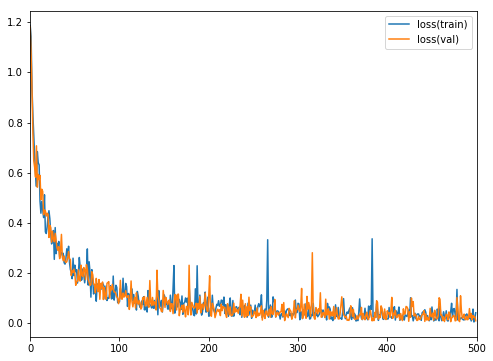

In [10]:
plt.figure(figsize=(8,6))
plt.plot(range(num_steps), stats[:,0], label="loss(train)")
plt.plot(range(num_steps), stats[:,3], label="loss(val)")
plt.legend()
plt.xlim(0, num_steps)
plt.savefig("loss.pdf")
plt.show()

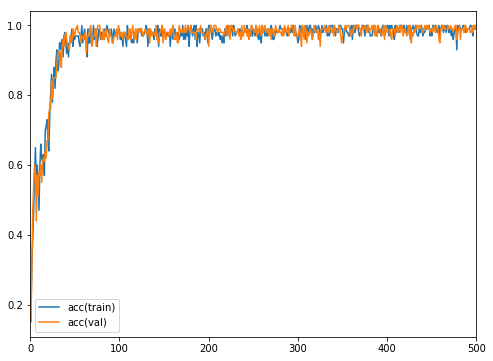

In [11]:
plt.figure(figsize=(8,6))
plt.plot(range(num_steps), stats[:,1], label="acc(train)")
plt.plot(range(num_steps), stats[:,4], label="acc(val)")
plt.legend()
plt.xlim(0, num_steps)
plt.savefig("acc.pdf")
plt.show()

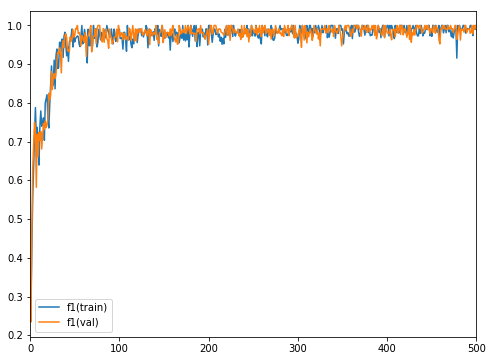

In [12]:
plt.figure(figsize=(8,6))
plt.plot(range(num_steps), stats[:,2], label="f1(train)")
plt.plot(range(num_steps), stats[:,5], label="f1(val)")
plt.legend()
plt.xlim(0, num_steps)
plt.savefig("acc.pdf")
plt.show()